## Climate time series analysis
* Charge and preprocess data
* Time series clustering 
* Causal analysis

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
from tensorflow.keras import layers, Model
from tslearn.clustering import TimeSeriesKMeans
from tslearn.barycenters import dtw_barycenter_averaging as dtw_avg
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
col_names = pd.read_csv('../dades/col_names.txt', header=None)
df = pd.DataFrame()

df.loc[:,'timestamp'] = pd.read_csv('../dades/data_per_pix/-0.5,-48.5.csv', header=None).loc[:,0].apply(datetime.datetime.fromtimestamp)

In [52]:
variables_names = ['Lag_RN_ERA_Ix5day_2', 'Lag_SM_GLEAM_ResPlusTrend_Sx5day_2','maxTXx_cum_T_ERA_2', 'monthly_Rx1day_P_CPCU']
variables_ind = [1486, 2109, 4225, 5007]

In [8]:
df = np.empty((len(os.listdir('../test_data/assaig1/')),385,4))
pixels = []
i = 0



for file in os.listdir('../test_data/assaig1/'):
    df[i,:,:] = pd.read_csv(os.path.join('../test_data/assaig1/', file), header=None)
    i += 1
    pixels.append(file)
    


In [9]:
inp = layers.Input(shape=(df.shape[1], df.shape[2]))
    

encoder = layers.TimeDistributed(layers.Dense(50, activation='tanh'))(inp)
encoder = layers.TimeDistributed(layers.Dense(10, activation='tanh'))(encoder)
latent = layers.TimeDistributed(layers.Dense(1, activation='tanh'))(encoder)
decoder = layers.TimeDistributed(layers.Dense(10, activation='tanh'))(latent)
decoder = layers.TimeDistributed(layers.Dense(50, activation='tanh'))(decoder)
out = layers.TimeDistributed(layers.Dense(4))(decoder)

autoencoder = Model(inputs=inp, outputs=out)
autoencoder.compile(optimizer='adam', loss='mse')


autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 385, 4)]          0         
                                                                 
 time_distributed_6 (TimeDis  (None, 385, 50)          250       
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 385, 10)          510       
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 385, 1)           11        
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 385, 10)          20        
 tributed)                                                 

In [10]:
ind = np.random.permutation(df.shape[0])
training_idx, test_idx = ind[:120], ind[120:]
x_train, x_test = df[training_idx,:,:], df[test_idx,:,:]

In [18]:
history = autoencoder.fit(x_train, x_train, epochs = 1000, validation_data= (x_test, x_test))

Epoch 1/1000
4/4 [==============================] - 0s 21ms/step - loss: 95.9254 - val_loss: 109.6893
Epoch 2/1000
4/4 [==============================] - 0s 13ms/step - loss: 96.2847 - val_loss: 110.2902
Epoch 3/1000
4/4 [==============================] - 0s 14ms/step - loss: 96.6767 - val_loss: 109.3782
Epoch 4/1000
4/4 [==============================] - 0s 14ms/step - loss: 97.2506 - val_loss: 110.8862
Epoch 5/1000
4/4 [==============================] - 0s 13ms/step - loss: 96.9662 - val_loss: 109.6894
Epoch 6/1000
4/4 [==============================] - 0s 13ms/step - loss: 97.2574 - val_loss: 111.8270
Epoch 7/1000
4/4 [==============================] - 0s 13ms/step - loss: 97.5137 - val_loss: 112.3860
Epoch 8/1000
4/4 [==============================] - 0s 13ms/step - loss: 96.9638 - val_loss: 112.0396
Epoch 9/1000
4/4 [==============================] - 0s 13ms/step - loss: 97.4532 - val_loss: 115.9664
Epoch 10/1000
4/4 [==============================] - 0s 13ms/step - loss: 98.3842 

In [19]:
encoder = Model(inputs=inp, outputs=latent)
encoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 385, 4)]          0         
                                                                 
 time_distributed_6 (TimeDis  (None, 385, 50)          250       
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 385, 10)          510       
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 385, 1)           11        
 tributed)                                                       
                                                                 
Total params: 771
Trainable params: 771
Non-trainable params: 0
_____________________________________________________________

In [20]:
data = encoder.predict(df)

6/6 [==============================] - 0s 2ms/step


In [22]:
data = data.reshape((len(os.listdir('../test_data/assaig1/')), 385))

In [23]:
data = pd.DataFrame(data, index = pixels)

In [24]:
model = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=100)
model.fit(data)

TimeSeriesKMeans(max_iter=100, metric='dtw', n_clusters=5)

In [25]:
results = pd.DataFrame()

In [35]:
results['group'] = model.predict(data)


c:\Users\Usuario\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 184 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [28]:
coord_x = []
coord_y = []

for i in range(len(pixels)):
    pixels[i] = pixels[i].replace('.csv', '')
    coord_x.append(float(pixels[i].split(',')[1]))
    coord_y.append(float(pixels[i].split(',')[0]))

In [29]:
results['coord_x'] = coord_x
results['coord_y'] = coord_y


In [22]:
results

,group,coord_x,coord_y
0,0,-48.5,-0.5
1,0,-49.5,-0.5
2,0,-50.5,-0.5
3,0,10.5,-0.5
4,0,11.5,-0.5
...,...,...,...
139,2,96.5,79.5
140,2,97.5,79.5
141,2,-66.5,80.5
142,2,-68.5,81.5


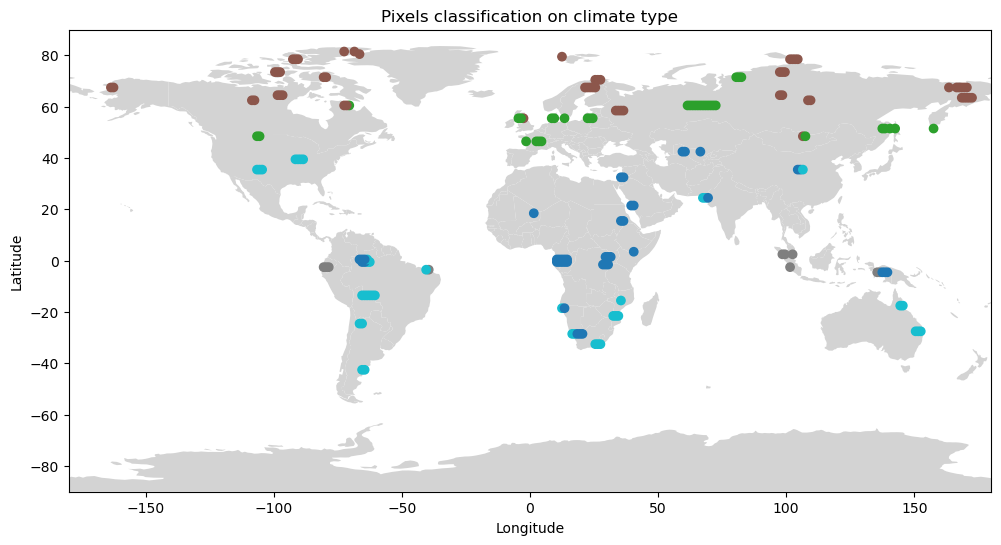

In [30]:
# From GeoPandas, our world map data
worldmap = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)


# Plotting our pixels classification by climate type
x = tuple(results['coord_x'])
y = tuple(results['coord_y'])
z = tuple(results['group'])


plt.scatter(x, y, c=z, cmap='tab10')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.title('Pixels classification on climate type')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [37]:
np.sum(results['group'] == 0)

42

In [59]:
mean_series = np.empty((len(set(results['group'])),4,385))

for i in set(results['group']):
    for j in range(4):
        mean_series[i,j,:] = dtw_avg(df[results['group'] == i,:,j], max_iter = 100).reshape([385,])

## causal analysis

In [62]:
# Imports

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

c:\Users\Usuario\anaconda3\lib\site-packages\tigramite\plotting.py:26: UserWarning: [Errno 2] No such file or directory: 'c:\\Users\\Usuario\\anaconda3\\lib\\site-packages\\tigramite\\..\\versions.py'
  warnings.warn(str(e))
c:\Users\Usuario\anaconda3\lib\site-packages\tigramite\independence_tests\gpdc.py:27: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
c:\Users\Usuario\anaconda3\lib\site-packages\tigramite\independence_tests\gpdc_torch.py:33: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
